help('modules')

In [1]:
import os

# Set OpenBLAS to use only 1 thread
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
from omegaconf import OmegaConf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py

from cmass.utils import get_source_path, cosmo_to_astropy

In [2]:
from cmass.survey.tools import xyz_to_sky
from cmass.survey.tools import sky_to_xyz
# Find a rotation scheme that aligns the two distributions
from scipy.spatial.transform import Rotation
from cmass.survey.tools import BOSS_angular, BOSS_veto, BOSS_redshift
from astropy.stats import scott_bin_width
from cmass.survey.ngc_selection import reweight
from cmass.diagnostics.tools import MA, calcPk
from cmass.diagnostics.summ import *

In [3]:
import pyfftw

In [4]:
import glob

In [5]:
from joblib import Parallel, delayed

In [6]:
wdir = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/L3000-N384/'

## Load and plot a test

In [7]:
# these are the number of 3gpc sim files in the directory
sims = np.arange(0, 2000, dtype=int)

In [8]:
mtng_cosmo = [0.3089, 0.0486, 0.6774, 0.9667, 0.8159]

In [9]:
# Load MTNG lightcone
mtng_cone = h5py.File(
    '/anvil/scratch/x-mho1/cmass-ili/mtng/nbody/L3000-N384/0/lightcone/hod00000_aug00000.h5', 'r')
mtng_cone.keys()

<KeysViewHDF5 ['dec', 'ra', 'z']>

In [10]:
mtng_rdz = np.stack([
    mtng_cone['ra'][...],
    mtng_cone['dec'][...],
    mtng_cone['z'][...]
], axis=1)

In [11]:
mtng_xyz = sky_to_xyz(mtng_rdz, cosmo=mtng_cosmo)

In [12]:
fastpm_mtnglike_sims_cosmo_array = np.zeros(
    (sims.shape[0], 5), dtype=np.float32)

for i, el in enumerate(sims):
    source_path = join(wdir, f'{el}')
    if not os.path.isdir(source_path):
        print('missing directory', el)
        continue
    if not os.path.isfile(join(source_path, 'config.yaml')):
        print(el)
        continue

    cfg = OmegaConf.load(join(source_path, 'config.yaml'))
    # print(OmegaConf.to_yaml(cfg))
    cosmo = cfg.nbody.cosmo
    fastpm_mtnglike_sims_cosmo_array[i] = cosmo
# cosmo_astropy = cosmo_to_astropy(params=cosmo)

missing directory 400
missing directory 401
missing directory 402
missing directory 403
missing directory 404
missing directory 405
missing directory 406
missing directory 407
missing directory 408
missing directory 409
missing directory 410
missing directory 411
missing directory 412
missing directory 413
missing directory 414
missing directory 415
missing directory 416
missing directory 417
missing directory 418
missing directory 419
missing directory 420
missing directory 421
missing directory 422
missing directory 423
missing directory 424
missing directory 425
missing directory 426
missing directory 427
missing directory 428
missing directory 429
missing directory 430
682
787
789
1447
1457
1481
1548
1605
1662
missing directory 1682
missing directory 1733
missing directory 1734
missing directory 1735
missing directory 1736
missing directory 1737
missing directory 1738
missing directory 1739
missing directory 1740
missing directory 1741
missing directory 1742
missing directory 1743


np.save('fastpm_mtnglike_sims_cosmo_array', fastpm_mtnglike_sims_cosmo_array)

fastpm_mtnglike_sims_cosmo_array = np.load('fastpm_mtnglike_sims_cosmo_array.npy')

In [13]:
test = h5py.File(
    '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/L3000-N384/0/ngc_lightcone/hod00001_aug00000.h5', 'r')

In [14]:
test.keys()

<KeysViewHDF5 ['dec', 'galidx', 'galsnap', 'ra', 'z']>

In [15]:
fastpm_mtnglike_sims_cosmo_array[0]

array([0.1755 , 0.06681, 0.7737 , 0.8849 , 0.6641 ], dtype=float32)

In [16]:
fastpm_mtnglike_sims_cosmo_array[-1]

array([0.2953 , 0.04701, 0.8017 , 0.8193 , 0.6627 ], dtype=float32)

In [17]:
inf_rdz = np.stack([
    test['ra'][...],
    test['dec'][...],
    test['z'][...]
], axis=1)

In [18]:
inf_xyz = sky_to_xyz(inf_rdz, cosmo=fastpm_mtnglike_sims_cosmo_array[0])

In [19]:
# load real observations
# cmass_file = join(wdir, 'cmass_ngc', 'cmass', 'L0-N0', '0', 'lightcone', 'hod000_aug000.h5')
cmass_file = '/anvil/scratch/x-mho1/cmass-ili/cmass_ngc/cmass/L0-N0/0/lightcone/hod00000_aug00000.h5'
with h5py.File(cmass_file, 'r') as f:
    ordz = np.stack([
        f['ra'][...],
        f['dec'][...],
        f['z'][...]
    ], axis=1)

oxyz = sky_to_xyz(ordz, cosmo=mtng_cosmo)

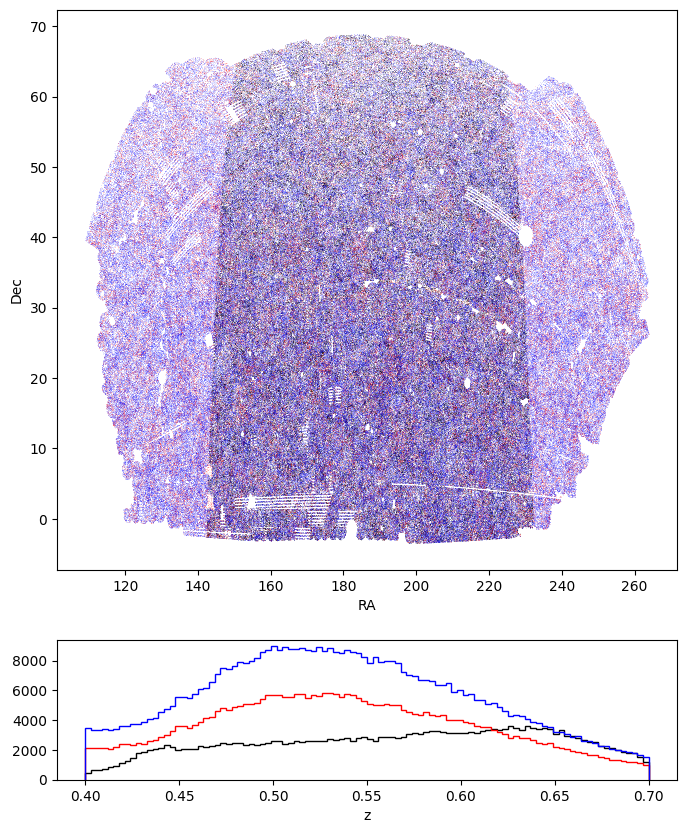

In [20]:
f, axs = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={
                      'height_ratios': [4, 1]})
axs[0].plot(mtng_rdz[:, 0], mtng_rdz[:, 1], 'k,', alpha=0.1)
axs[0].plot(inf_rdz[:, 0], inf_rdz[:, 1], 'r,', alpha=0.1)
axs[0].plot(ordz[:, 0], ordz[:, 1], 'b,', alpha=0.1)
axs[0].set(xlabel='RA', ylabel='Dec')

axs[1].hist(inf_rdz[:, 2], bins=100, histtype='step', color='k')
axs[1].hist(mtng_rdz[:, 2], bins=100, histtype='step', color='r')
axs[1].hist(ordz[:, 2], bins=100, histtype='step', color='b')
axs[1].set(xlabel='z')

In [21]:
# Rotate -dec
ang = -0.03*np.pi
Rz = Rotation.from_rotvec(
    np.array([1, -1, 0])/np.sqrt(2)*ang)
# rxyz = Rz.apply(rxyz)

# Rotate +ra
ang = np.pi*0.79
Rr = Rotation.from_rotvec([0, 0, ang])
# rxyz = Rr.apply(rxyz)

# Convert to sky coordinates
# rrdz = xyz_to_sky(rxyz, vel=None, cosmo=cosmo)

In [22]:
# Cut 3 gpc data in the reference frame of mtng

# Rotate to first octant
ioxyz = Rr.inv().apply(inf_xyz)
ioxyz = Rz.inv().apply(ioxyz)

# Apply cuts
iordz = xyz_to_sky(ioxyz, vel=None, cosmo=fastpm_mtnglike_sims_cosmo_array[0])
mask = (0 < iordz[:, 0]) & (iordz[:, 0] < 90)
mask &= (0 < iordz[:, 1]) & (iordz[:, 1] < 90)
ioxyz = ioxyz[mask]

# Rotate back
iioxyz = Rz.apply(ioxyz)
iioxyz = Rr.apply(iioxyz)
iiordz = xyz_to_sky(iioxyz, vel=None, cosmo=fastpm_mtnglike_sims_cosmo_array[0])

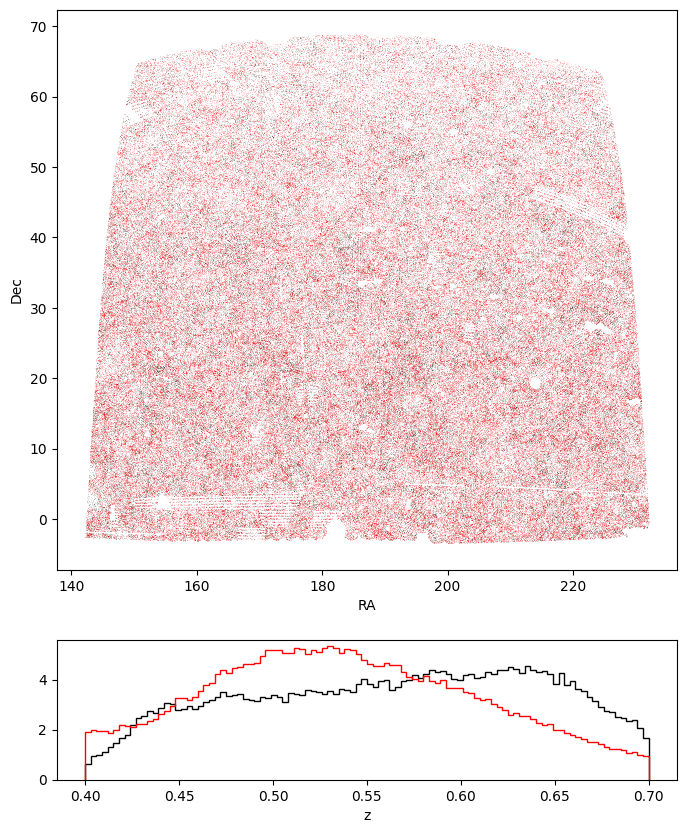

In [23]:
f, axs = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={
                      'height_ratios': [4, 1]})
axs[0].plot(iiordz[:, 0], iiordz[:, 1], 'k,', alpha=0.1)
axs[0].plot(mtng_rdz[:, 0], mtng_rdz[:, 1], 'r,', alpha=0.1)
axs[0].set(xlabel='RA', ylabel='Dec')

axs[1].hist(iiordz[:, 2], bins=100, histtype='step', color='k', density=True)
axs[1].hist(mtng_rdz[:, 2], bins=100, histtype='step', color='r', density=True)
axs[1].set(xlabel='z')

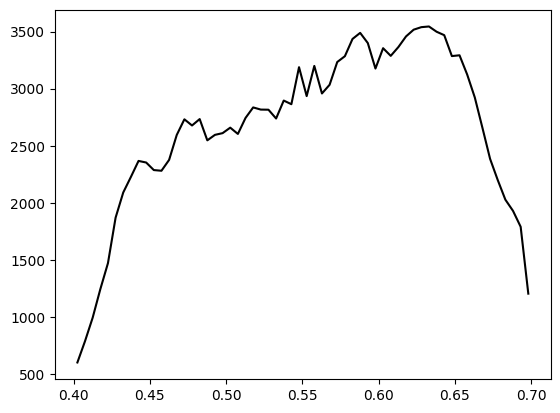

In [24]:
_, be = scott_bin_width(iiordz[:, 2], return_bins=True)
hobs, be = np.histogram(iiordz[:, 2], bins=be)

plt.plot(0.5*(be[1:]+be[:-1]), hobs, 'k-')

In [25]:
axyz = sky_to_xyz(mtng_rdz, cosmo=mtng_cosmo)
bxyz = sky_to_xyz(iiordz, cosmo=fastpm_mtnglike_sims_cosmo_array[0])

offset = axyz.min(axis=0)
axyz -= offset
bxyz -= offset

In [26]:
offset

array([-1743.42060678, -1361.00052226,  -109.34701731])

offset = np.array([-1743.42060678, -1361.00052226,  -109.34701731])
offset

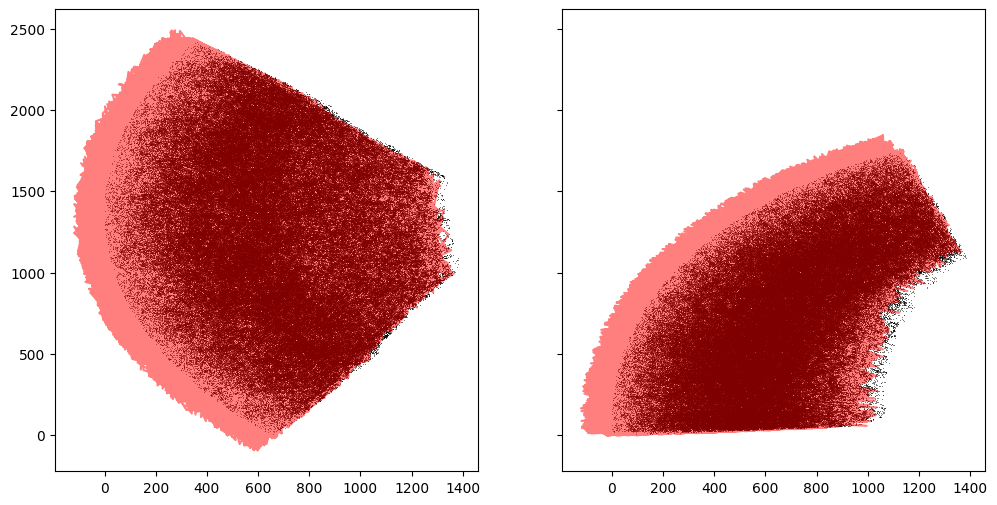

In [28]:
f, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].plot(axyz[:, 0], axyz[:, 1], 'k,', alpha=0.5)
axs[1].plot(axyz[:, 0], axyz[:, 2], 'k,', alpha=0.5)
axs[0].plot(bxyz[:, 0], bxyz[:, 1], 'r', alpha=0.5)
axs[1].plot(bxyz[:, 0], bxyz[:, 2], 'r', alpha=0.5)

In [29]:
adelta_cut = MA(axyz.astype(np.float32), L=2000, N=256)
ak, aPk_cut = calcPk(adelta_cut, L=2000, threads=32)

In [30]:
ak.shape

(221,)

np.save('k_array', ak)

In [31]:
bdelta_cut = MA(bxyz.astype(np.float32), L=2000, N=256)

In [32]:
bk, bPk_cut = calcPk(bdelta_cut, L=2000)

In [33]:
adelta_2 = MA(axyz.astype(np.float32), L=3000, N=384)
ak_2, aPk_2 = calcPk(adelta_2, L=3000)

In [34]:
ak_2.shape

(332,)

In [ ]:
bdelta_2 = MA(bxyz.astype(np.float32), L=3000, N=384)
bk_2, bPk_2 = calcPk(bdelta_2, L=3000)

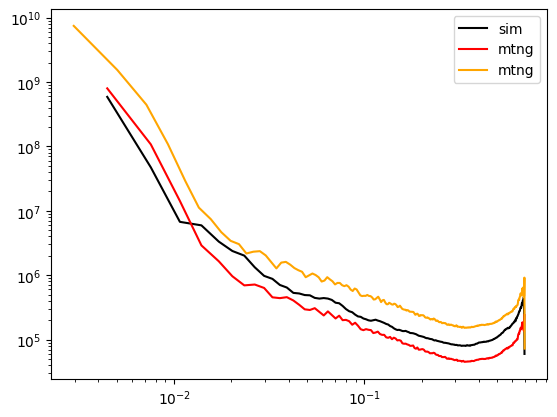

In [35]:
plt.loglog(bk, bPk_cut[..., 0], 'k-', label='sim')
plt.loglog(ak, aPk_cut[..., 0], 'r-', label='mtng')
# plt.loglog(bk_2, bPk_2[...,0], 'grey', label='sim')
plt.loglog(ak_2, aPk_2[..., 0], 'orange', label='mtng')
plt.legend()

# let's do for all sims

## we'll try to "cut" the volume just so we can compare mtng to the cmass sims

In [38]:
# let's get how many models in each sim
n_hods = np.zeros(2000)
count = 0
for i, el in enumerate(sims):
    path = wdir+f'{el}/ngc_lightcone/'
    if not os.path.isdir(path):
        count += 1
        continue
    all_files = os.listdir(path)
    n_hods[i] = len(all_files)

In [39]:
sims_less_5_hods = np.where(np.logical_and(n_hods != 5, n_hods != 0))[0]

In [40]:
# number realizations not done
count

247

In [41]:
for el in sims_less_5_hods:
    path = wdir+f'{el}/ngc_lightcone/'
    all_files = os.listdir(path)
    print(el, len(all_files))

156 1
212 1
249 1
458 1
526 1
791 2
817 4
1001 4
1170 1
1211 3
1368 4


In [42]:
N_models = 2000*5

fastpm_mtnglike_pk_array_3000_384 = np.zeros((N_models, 332), dtype=np.float32)

fastpm_mtnglike_pk_array = np.load('fastpm_mtnglike_pk_array.npy')

In [ ]:
hod_count = 0
for el in [0, 1]:  # sims:
    if el % 20 == 0:
        print(el, hod_count)

    if not os.path.exists(join(wdir + f'{el}/', 'config.yaml')):
        print(el)
        return
    cfg = OmegaConf.load(join(wdir + f'{el}/', 'config.yaml'))
    sim_cosmo = cfg.nbody.cosmo

    path = wdir+f'{el}/ngc_lightcone/'

    if not os.path.exists(path):
        return

    all_files = os.listdir(path)
    for i, file in enumerate(all_files):
        with h5py.File(path+file, 'r') as gals:
            if not 'ra' in gals:
                return
            print(file)
            sim_rdz = np.stack([
                gals['ra'][...],
                gals['dec'][...],
                gals['z'][...]
            ], axis=1)

            sim_xyz = sky_to_xyz(sim_rdz, cosmo=sim_cosmo)

            # Cut 3 gpc data in the reference frame of mtng

            # Rotate to mtng
            isim_xyz = Rr.inv().apply(sim_xyz)
            isim_xyz = Rz.inv().apply(isim_xyz)

            # Apply cuts
            isim_rdz = xyz_to_sky(isim_xyz, vel=None, cosmo=sim_cosmo)
            mask = (0 < isim_rdz[:, 0]) & (isim_rdz[:, 0] < 90)
            mask &= (0 < isim_rdz[:, 1]) & (isim_rdz[:, 1] < 90)
            isim_xyz = isim_xyz[mask]

            # Rotate back
            iisim_xyz = Rz.apply(isim_xyz)
            iisim_xyz = Rr.apply(iisim_xyz)
            iisim_rdz = xyz_to_sky(iisim_xyz, vel=None, cosmo=sim_cosmo)

            sxyz = sky_to_xyz(iisim_rdz, cosmo=sim_cosmo)
            sxyz -= offset

            delta = MA(sxyz.astype(np.float32), L=2000, N=256)
            k, Pk = calcPk(delta, L=2000, threads=32)

            fastpm_mtnglike_pk_array_3000_384[hod_count] = Pk[..., 0]
            # cosmo_array[hod_count] = sim_cosmo
            hod_count += 1

            np.save('fastpm_mtnglike_pk_array', fastpm_mtnglike_pk_array)

In [ ]:
hod_count

import traceback

def do_rot_get_pk(el):
    try:
        path = wdir + f'{el}/ngc_lightcone/'

        if not os.path.exists(path):
            print(f"Path {path} does not exist. Skipping.")
            return
        
        cfg = OmegaConf.load(join(wdir + f'{el}/', 'config.yaml'))
        sim_cosmo = cfg.nbody.cosmo

        all_files = os.listdir(path)
        for i, file in enumerate(all_files):
            try:
                with h5py.File(os.path.join(path, file), 'r') as gals:
                    if 'ra' not in gals:
                        continue

                    sim_rdz = np.stack([
                        gals['ra'][...],
                        gals['dec'][...],
                        gals['z'][...]
                    ], axis=1)

                    #sim_cosmo = fastpm_mtnglike_sims_cosmo_array[el]
                    sim_xyz = sky_to_xyz(sim_rdz, cosmo=sim_cosmo)

                    # Rotate to mtng
                    isim_xyz = Rr.inv().apply(sim_xyz)
                    isim_xyz = Rz.inv().apply(isim_xyz)

                    # Apply cuts
                    isim_rdz = xyz_to_sky(isim_xyz, vel=None, cosmo=sim_cosmo)
                    mask = (0 < isim_rdz[:, 0]) & (isim_rdz[:, 0] < 90)
                    mask &= (0 < isim_rdz[:, 1]) & (isim_rdz[:, 1] < 90)
                    isim_xyz = isim_xyz[mask]

                    # Rotate back
                    iisim_xyz = Rz.apply(isim_xyz)
                    iisim_xyz = Rr.apply(iisim_xyz)
                    iisim_rdz = xyz_to_sky(iisim_xyz, vel=None, cosmo=sim_cosmo)

                    sxyz = sky_to_xyz(iisim_rdz, cosmo=sim_cosmo)
                    sxyz -= offset
                    delta = MA(sxyz.astype(np.float32), L=3000, N=384)

                    k, Pk = calcPk(delta, L=3000, threads=16)

                    fastpm_mtnglike_pk_array[el + i] = Pk[..., 0]
                    cosmo_array[el + i] = sim_cosmo
            except Exception as e:
                print(f"Error processing file {file}: {e}")
                traceback.print_exc()

    except Exception as outer_e:
        print(f"Fatal error processing element {el}: {outer_e}")
        traceback.print_exc()

for el in [0,1]:
    print(el)
    do_rot_get_pk(el)

n_jobs = 16  # Use 32 cores
Parallel(n_jobs=n_jobs)(delayed(do_rot_get_pk)(el) for el in sims)

In [ ]:
do_rot_get_pk(0)

In [42]:
fastpm_mtnglike_pk_array = np.load('fastpm_mtnglike_pk_array.npy')

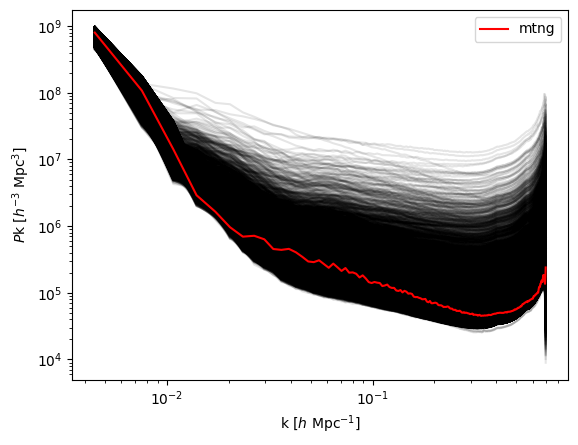

In [43]:
for i, el in enumerate(fastpm_mtnglike_pk_array):
    if not np.any(el) == True:
        continue
    plt.loglog(bk, el, 'k-', alpha=0.1)
plt.loglog(ak, aPk[..., 0], 'r-', label='mtng')
plt.xlabel(r'${\rm k}\ [h\ {\rm Mpc}^{-1}]$')
plt.ylabel(r'$P{\rm k}\ [h^{-3}\ {\rm Mpc}^3]$')
plt.legend()

np.save('mtng_pk', aPk[...,0])